In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime
import calendar

In [29]:
DATA_CLEANED_PATH = '../data/interim/data_no_cancellations.parquet'
DATA_CANCELED_PATH = '../data/interim/data_cancellations.parquet'

In [31]:
data_cancellations = pd.read_parquet(DATA_CANCELED_PATH)
data_no_cancellations = pd.read_parquet(DATA_CLEANED_PATH)
data_cancellations.head()


,hotel_id,datum_dolaska,datum_otkazivanja_rezervacije,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,gost_id,ukupno_gostiju,duljina_boravka,raspon_dolazak_rezervacija
0,0,2015-07-01,2015-05-06,PRT,2,1,61.437192,1075633,2,3,1
1,0,2015-07-01,2015-04-22,PRT,2,2,150.365262,1056139,2,3,3
2,0,2015-07-01,2015-06-23,PRT,2,3,142.635814,1020092,2,4,75
3,0,2015-07-01,2015-05-11,PRT,2,3,113.277032,1018277,2,7,178
4,0,2015-07-01,2015-05-29,PRT,0,3,105.416363,1035627,2,10,181


Opis kolona:
- hotel_id : int, dvije vrste hotela: hotel 0 i hotel 1
- datum_dolaska :  datum kada bi gost trebao stići u hotel
- datum_otkazivanja_rezervacije: samo za podatkovni okvir s podacima o otkazanim rezervacijama
- zemlja_gosta : zemlja iz koje gost dolazi. Kategorije su zapisane u ISO 3155–3:2013 formatu
- kanal_prodaje_id : id kanala prodaje preko kojeg je rezervacija napravljena (primjeri: direktna rezervacija, agencija, online)
- tip_sobe_id : id tipa sobe koju je gost rezervirao
- cijena_nocenja : cijena jednog noćenja za pojedinu rezeraciju
- gost_id : identifikacijski broj gosta
- ukupno_gostiju : int, broj ukupnog broja gostiju za danu rezervaciju
- duljina_boravka: dani boravka osoba u hotelu u danoj rezervaciji
- raspon_dolazak_rezervacija : razlika u brojima dana izmedu dana dolaska gosta i dana kreiranja rezervacije

In [32]:
hotel_zero_cancellations = data_cancellations[data_cancellations['hotel_id'] == 0]
hotel_one_cancellations = data_cancellations[data_cancellations['hotel_id'] == 1]

assert (len(hotel_zero_cancellations)+ len(hotel_one_cancellations)) == len(data_cancellations)

In [33]:
hotel_zero_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 0]
hotel_one_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 1]

assert (len(hotel_zero_no_cancellations)+ len(hotel_one_no_cancellations)) == len(data_no_cancellations)

In [34]:
percent_hotel_zero_cancellations = (len(hotel_zero_cancellations) / len(data_cancellations)) * 100
percent_hotel_one_cancellations = (len(hotel_one_cancellations) / len(data_cancellations)) * 100
percent_hotel_zero_no_cancellations = (len(hotel_zero_no_cancellations) / len(data_no_cancellations)) * 100
percent_hotel_one_no_cancellations = (len(hotel_one_no_cancellations) / len(data_no_cancellations)) * 100

print(f"Prvi hotel ima {percent_hotel_zero_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")
print(f"Drugi hotel ima {percent_hotel_one_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")

print(f"Prvi hotel ima {percent_hotel_zero_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")
print(f"Drugi hotel ima {percent_hotel_one_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")

Prvi hotel ima 25.105485232067508 % svih zapisa o otkazima u originalnom podatkovnom skupu
Drugi hotel ima 74.89451476793249 % svih zapisa o otkazima u originalnom podatkovnom skupu
Prvi hotel ima 38.05994373512227 % svih zapisa bez otkaza u originalnom podatkovnom skupu
Drugi hotel ima 61.94005626487773 % svih zapisa bez otkaza u originalnom podatkovnom skupu


### Zanimaju nas zemlje podrijetla gostiju

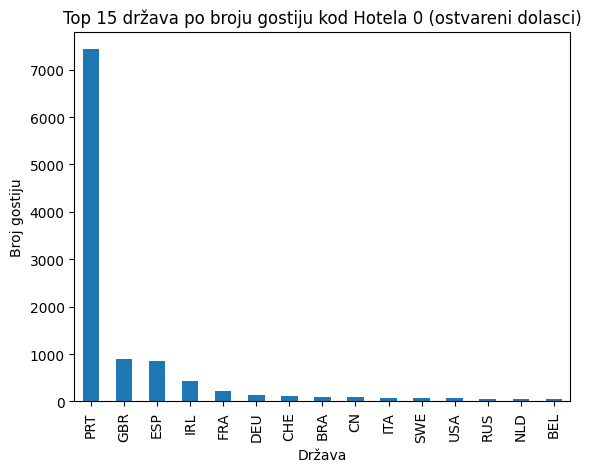

In [46]:
n = 15
top_countries_cancel_0 = hotel_zero_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_0.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

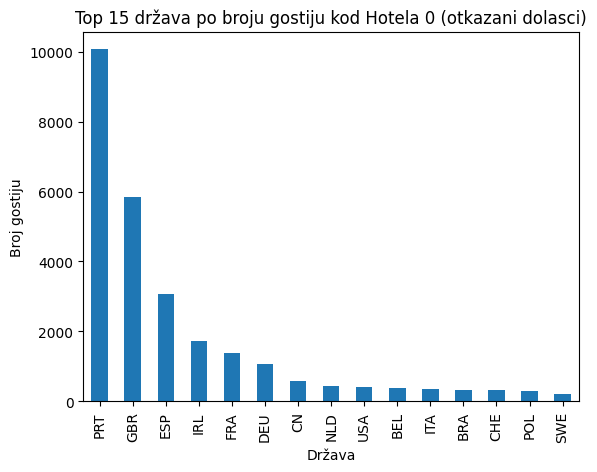

In [47]:
n = 15
top_countries_no_cancel_0 = hotel_zero_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_0.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (otkazani dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

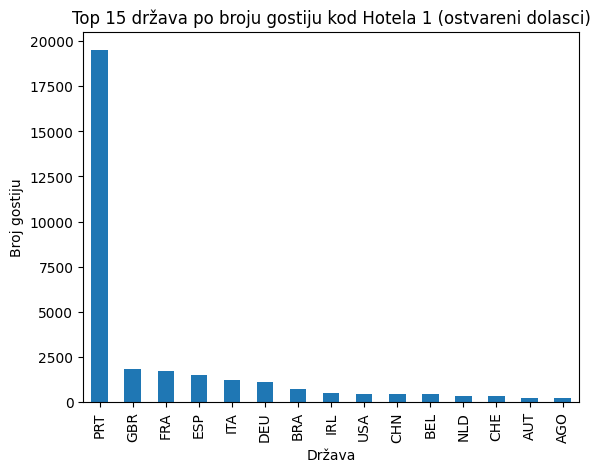

In [48]:
n = 15
top_countries_cancel_1 = hotel_one_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_1.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 1 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

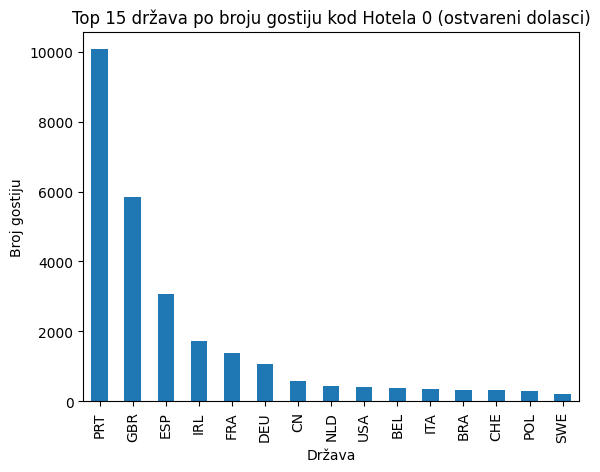

In [49]:
n = 15
top_countries_no_cancel_1 = hotel_zero_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_1.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

In [60]:
min_date = data_no_cancellations['datum_dolaska'].min()
max_date = data_no_cancellations['datum_dolaska'].max()

print(f"Svi zapisi su u razdoblju od {min_date} do {max_date}")

Svi zapisi su u razdoblju od 2015-01-01 00:00:00 do 2017-12-31 00:00:00


# Promatranje cijene u hotelima

- Gledamo cijene na sljedeći način:
    - za svaku rezervaciju dobijemo cijenu po osobi
    - za svaki dan/tjedan/mjesec dobijemo prosječnu cijenu (uzimajući i ne uzimajući godinu u obzir)
    - napravimo isto za različite vrste soba i kanala prodaje
    - napravimo sve prethodno za ostvarene i neostvarene rezervacije obaju hotela

In [75]:
# DODANO ZBOG PODIGNUTOG UPOZORENJA OD PYTHONA
hotel_zero_cancellations = hotel_zero_cancellations.copy()
hotel_one_cancellations = hotel_one_cancellations.copy()
hotel_zero_no_cancellations = hotel_zero_no_cancellations.copy()
hotel_one_no_cancellations = hotel_one_no_cancellations.copy()

In [81]:
hotel_zero_cancellations['datum_dolaska'] = pd.to_datetime(hotel_zero_cancellations['datum_dolaska'])
hotel_one_cancellations['datum_dolaska'] = pd.to_datetime(hotel_one_cancellations['datum_dolaska'])
hotel_zero_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_zero_no_cancellations['datum_dolaska'])
hotel_one_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_one_no_cancellations['datum_dolaska'])

KORAK 1: Cijena po osobi po rezervaciji

In [84]:
hotel_zero_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_zero_cancellations['cijena_nocenja'] / hotel_zero_cancellations['ukupno_gostiju']
hotel_one_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_one_cancellations['cijena_nocenja'] / hotel_one_cancellations['ukupno_gostiju']
hotel_zero_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_zero_no_cancellations['cijena_nocenja'] / hotel_zero_no_cancellations['ukupno_gostiju']
hotel_one_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_one_no_cancellations['cijena_nocenja'] / hotel_one_no_cancellations['ukupno_gostiju']

### HOTEL 0 otkazani dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [89]:
average_daily_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [90]:
overall_average_monthly_price = hotel_zero_cancellations.groupby(hotel_zero_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price = hotel_zero_cancellations.groupby(hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()


KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [91]:
average_by_daily_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [92]:
average_by_daily_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 0 ostvareni dolasci

In [ ]:
KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [ ]:
KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [ ]:
KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

### HOTEL 1 ostvareni dolasci

In [ ]:
KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [ ]:
average_daily_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()

In [ ]:
overall_average_monthly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby(hotel_zero_no_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby(hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

In [ ]:
KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [ ]:
average_by_daily_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

In [ ]:
KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [ ]:
average_by_daily_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 1 otkazani dolasci

In [ ]:
KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [ ]:
average_daily_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [ ]:

overall_average_monthly_price_hotel_one = hotel_one_cancellations.groupby(hotel_one_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_one = hotel_one_cancellations.groupby(hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

In [ ]:
KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [ ]:
average_by_daily_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

In [ ]:
KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [ ]:
age_by_daily_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

##  Vizualizacije promjena cijena

### HOTEL 0 otkazani dolasci

<Figure size 2800x2000 with 0 Axes>

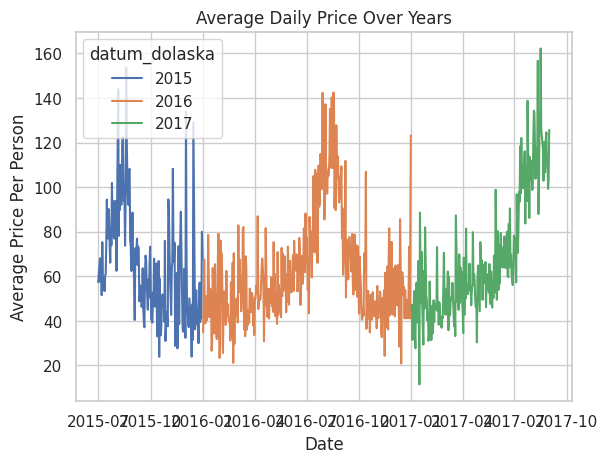

<Figure size 2800x2000 with 0 Axes>

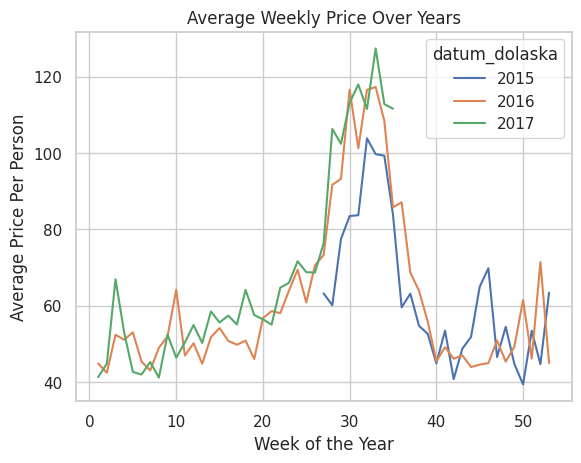

<Figure size 2800x2000 with 0 Axes>

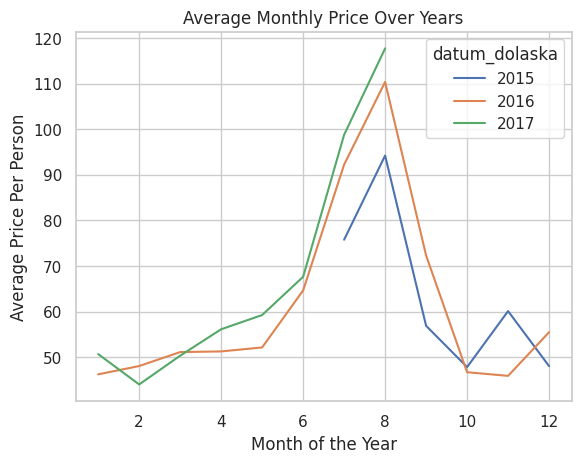

In [102]:
plt.figure(figsize=(28, 20))
average_daily_price.unstack(level=0).plot()  # Unstacking the year for separate lines
plt.title('Average Daily Price Over Years')
plt.xlabel('Date')
plt.ylabel('Average Price Per Person')
plt.show()

plt.figure(figsize=(28, 20))
average_weekly_price.unstack(level=0).plot()  # Unstacking the year
plt.title('Average Weekly Price Over Years')
plt.xlabel('Week of the Year')
plt.ylabel('Average Price Per Person')
plt.show()

plt.figure(figsize=(28, 20))
average_monthly_price.unstack(level=0).plot()  # Unstacking the year
plt.title('Average Monthly Price Over Years')
plt.xlabel('Month of the Year')
plt.ylabel('Average Price Per Person')
plt.show()

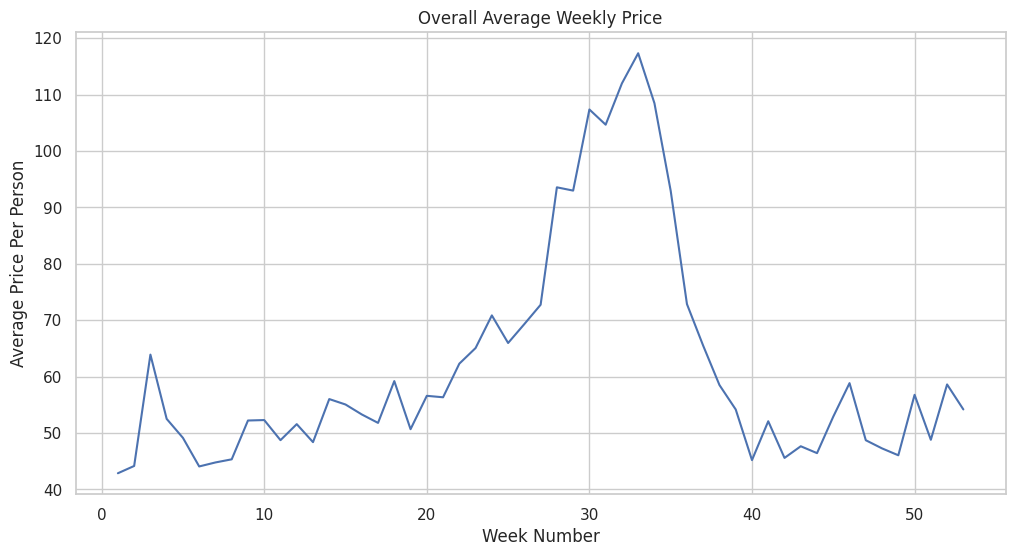

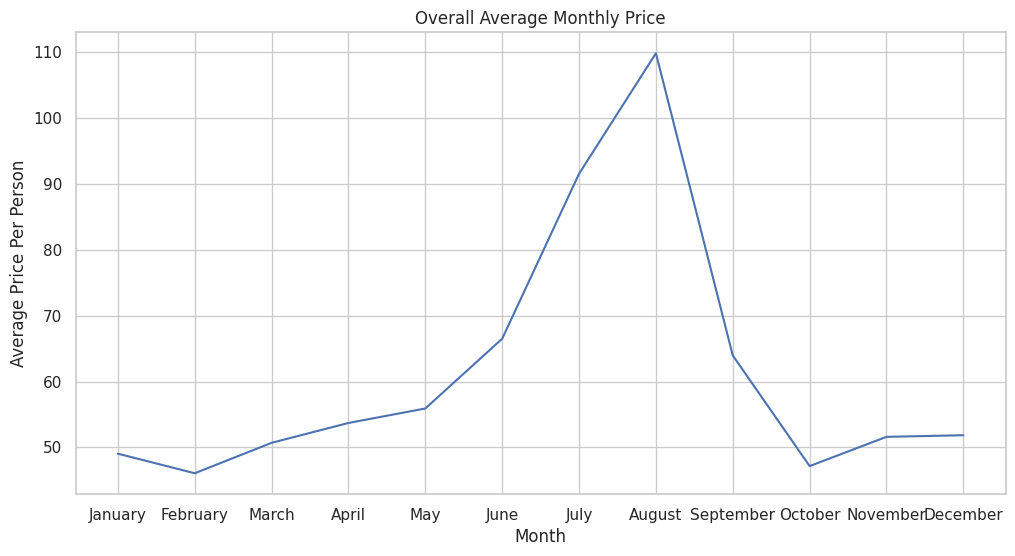

In [97]:
month_names = [calendar.month_name[i] for i in range(1, 13)]

plt.figure(figsize=(12, 6))
overall_average_monthly_price.plot()
plt.title('Overall Average Monthly Price')
plt.xticks(range(1, 13), month_names)  
plt.xlabel('Month')
plt.ylabel('Average Price Per Person')
plt.show()

plt.figure(figsize=(12, 6))
overall_average_weekly_price.plot()
plt.title('Overall Average Weekly Price')
plt.xlabel('Week Number')
plt.ylabel('Average Price Per Person')
plt.show()


<Figure size 2800x2000 with 0 Axes>

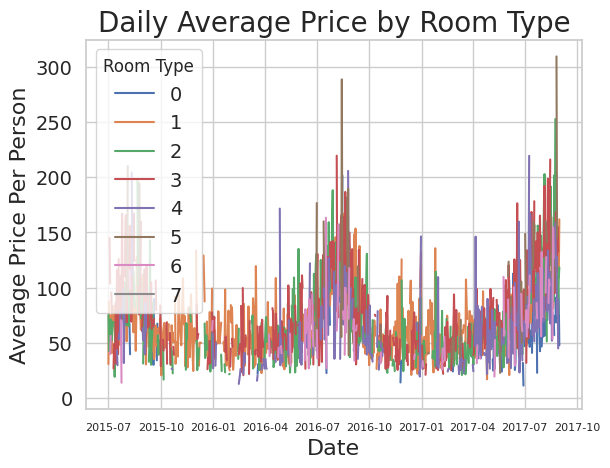

In [120]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type.unstack(level=1).plot()  # Unstacking the room type
plt.title('Daily Average Price by Room Type', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Room Type', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

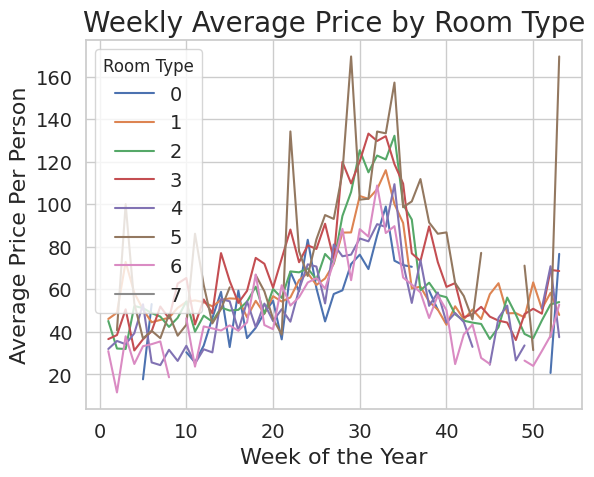

In [109]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type.unstack(level=1).plot()  # Unstacking the room type
plt.title('Weekly Average Price by Room Type', fontsize=20)
plt.xlabel('Week of the Year', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Room Type', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

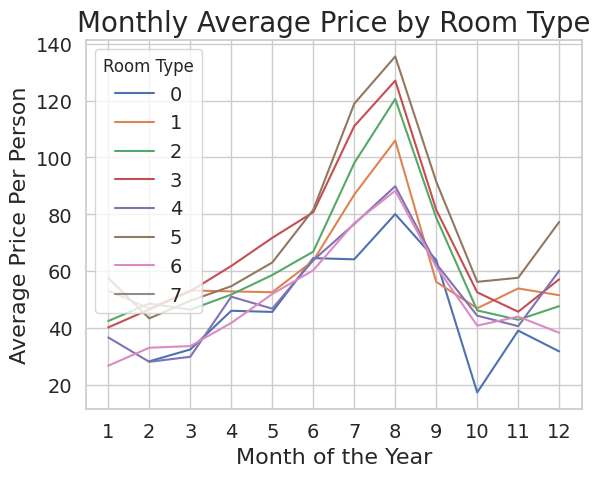

In [110]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type.unstack(level=1).plot()  # Unstacking the room type
plt.title('Monthly Average Price by Room Type', fontsize=20)
plt.xlabel('Month of the Year', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Room Type', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

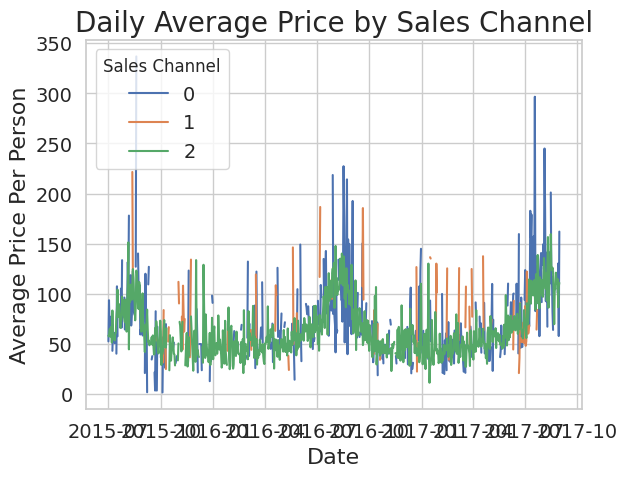

In [111]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel.unstack(level=1).plot()  # Unstacking the sales channel
plt.title('Daily Average Price by Sales Channel', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Sales Channel', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

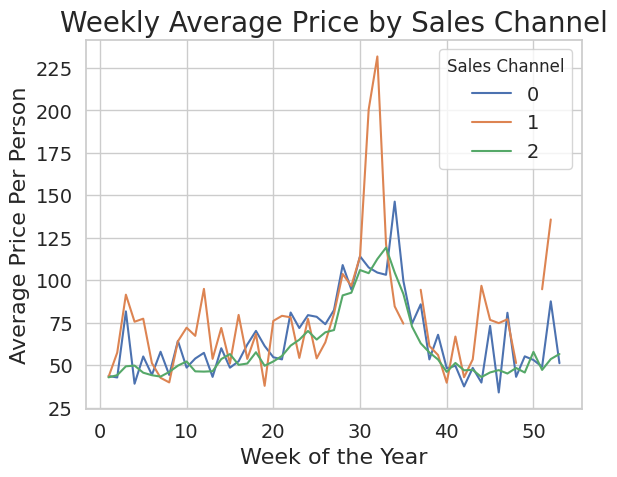

In [112]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel.unstack(level=1).plot()  # Unstacking the sales channel
plt.title('Weekly Average Price by Sales Channel', fontsize=20)
plt.xlabel('Week of the Year', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Sales Channel', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

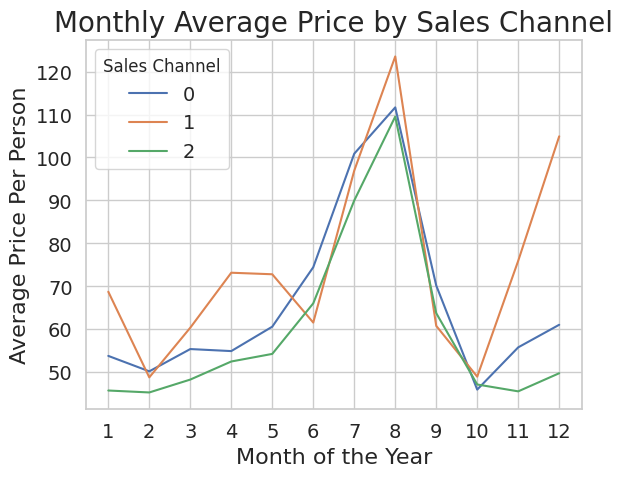

In [113]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel.unstack(level=1).plot()  # Unstacking the sales channel
plt.title('Monthly Average Price by Sales Channel', fontsize=20)
plt.xlabel('Month of the Year', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Sales Channel', fontsize=14)
plt.show()


### HOTEL 0 ostvareni dolasci

### HOTEL 1 otkazani dolasci

### HOTEL 1 ostvareni dolasci

# Dalje

In [13]:
mean_price_hotel_zero, mean_price_hotel_one  =np.mean(hotel_zero['cijena_nocenja']), np.mean(hotel_one['cijena_nocenja'])
std_price_hotel_zero, std_price_hotel_one  =np.std(hotel_zero['cijena_nocenja']), np.std(hotel_one['cijena_nocenja'])


In [14]:
q11 = np.percentile(hotel_zero['cijena_nocenja'], 25)
q31 = np.percentile(hotel_zero['cijena_nocenja'], 75)
iqr1 = q31 - q11
threshold1 = 1.5 * iqr1
outliers1 = np.where((hotel_zero['cijena_nocenja'] < q11 - threshold1) | (hotel_zero['cijena_nocenja'] > q31 + threshold1))
 
print(len(outliers1[0])/len(hotel_zero['cijena_nocenja'])*100)


7.081679027143107


In [15]:
q12 = np.percentile(hotel_one['cijena_nocenja'], 25)
q32 = np.percentile(hotel_one['cijena_nocenja'], 75)
iqr2 = q31 - q12
threshold2 = 1.5 * iqr2
outliers2 = np.where((hotel_one['cijena_nocenja'] < q12 - threshold2) | (hotel_one['cijena_nocenja'] > q32 + threshold2))
 
print(len(outliers2[0])/len(hotel_one['cijena_nocenja'])*100)


3.0456147442618398


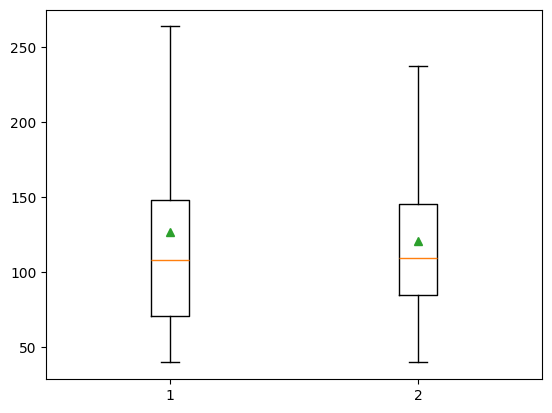

In [16]:
dict = plt.boxplot([hotel_zero['cijena_nocenja'], hotel_one['cijena_nocenja']], showfliers=False,showmeans=True)

### Datumi gdje je datum otkazivanja nakon datuma dolaska

In [17]:
krivi_datumi = df_copy[df_copy['datum_otkazivanja_rezervacije'] > df_copy['datum_dolaska']]
print(f"Ukupno {len(krivi_datumi)} redaka s neispravnim datumima")
print(krivi_datumi.head(3))

Ukupno 1953 redaka s neispravnim datumima
       hotel_id datum_dolaska datum_kreiranja_rezervacije datum_odjave  \
40048         1    2015-01-01                  2015-01-01   2015-01-05   
40054         1    2015-05-02                  2015-01-17   2015-05-06   
40055         1    2015-05-02                  2015-03-28   2015-05-07   

      datum_otkazivanja_rezervacije  broj_odraslih_gostiju  \
40048                    2015-07-01                      2   
40054                    2015-06-25                      1   
40055                    2015-07-02                      2   

       broj_djece_gostiju zemlja_gosta  kanal_prodaje_id  tip_sobe_id  \
40048                 0.0          PRT                 2            1   
40054                 0.0          PRT                 2            1   
40055                 0.0          PRT                 2            1   

       cijena_nocenja status_rezervacije  rezervacija_id  gost_id  \
40048       97.930547           Canceled         1

#### Obrađivanje stupca datum dolaska 

In [18]:
def process_arrival_date(df, years=None):
    df['datum_dolaska'] = pd.to_datetime(df['datum_dolaska'], errors='coerce')

    df['year'] = df['datum_dolaska'].dt.year
    df['month'] = df['datum_dolaska'].dt.month
    df['week'] = df['datum_dolaska'].dt.isocalendar().week.astype(float)
    df['day'] = df['datum_dolaska'].dt.day
    df['dayofweek'] = df['datum_dolaska'].dt.dayofweek
    df['quarter'] = df['datum_dolaska'].dt.quarter
    df['dayofyear'] = df['datum_dolaska'].dt.dayofyear

    if years is not None:
        if not isinstance(years, list):
            years = [years]  
        df = df[df['year'].isin(years)]

    return df


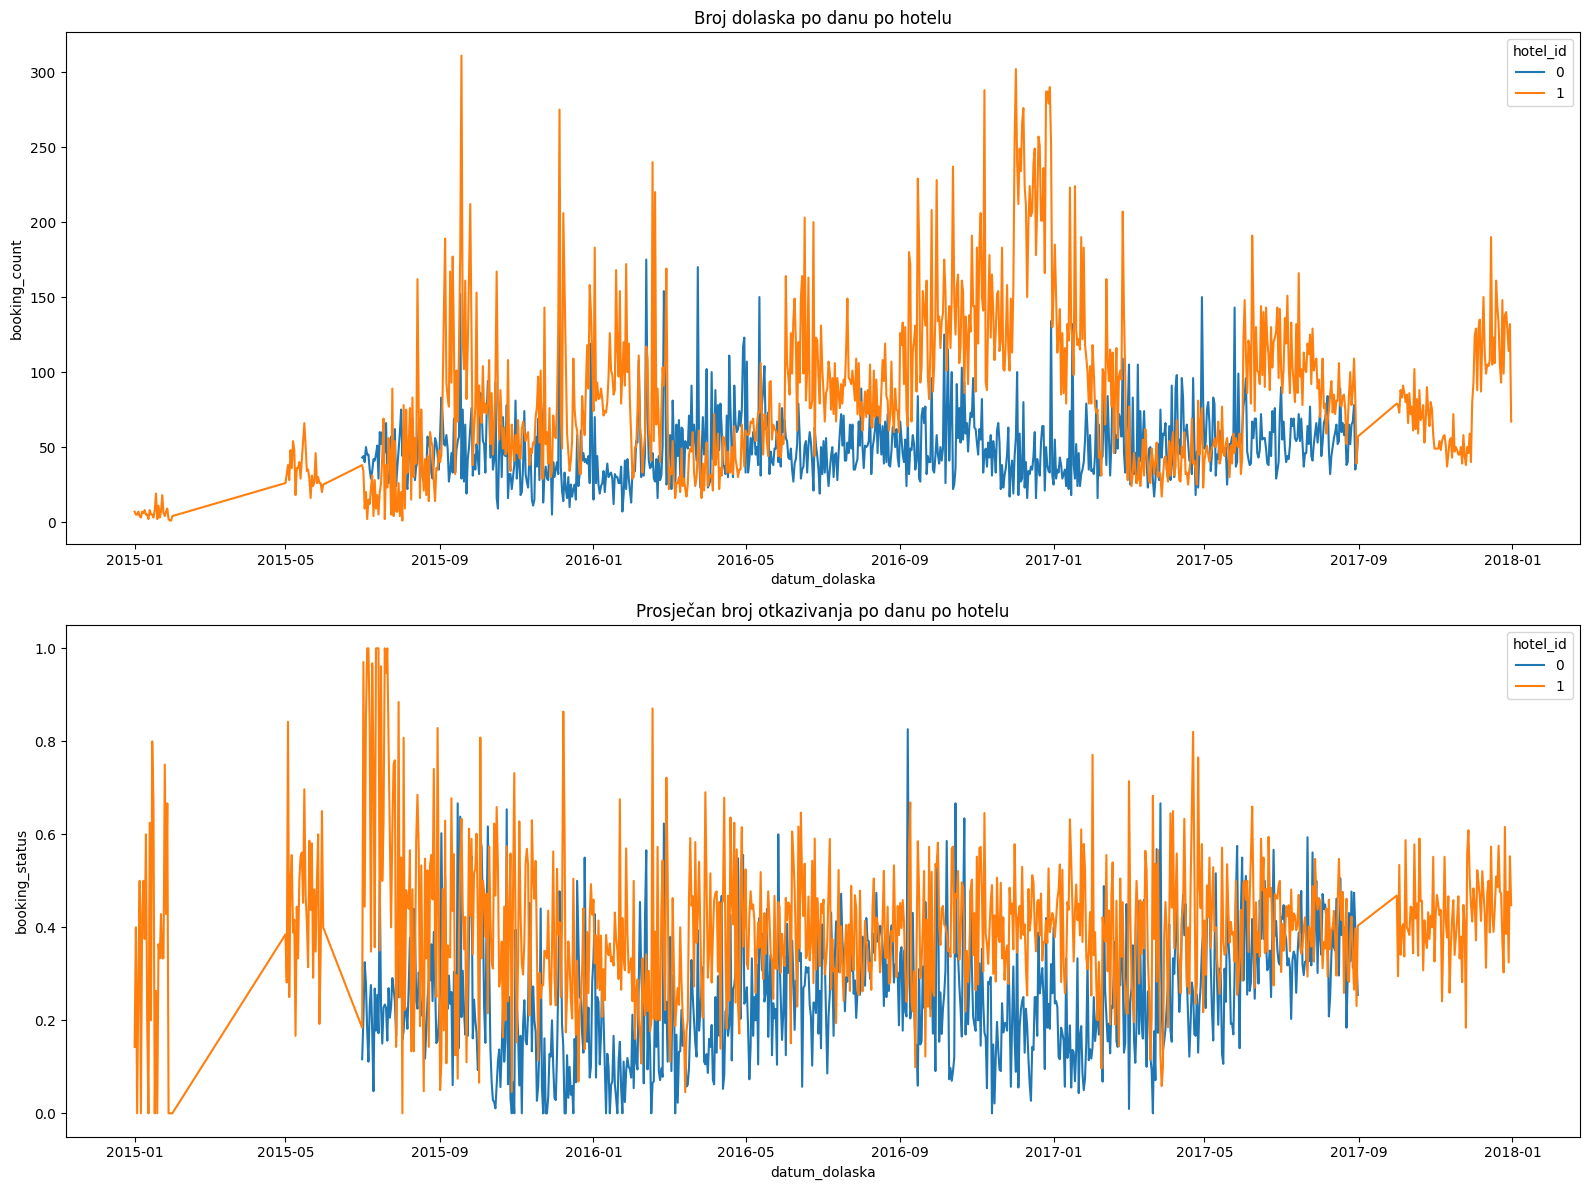

In [19]:
df = process_arrival_date(df_copy)

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu')

plt.tight_layout()
plt.show()

### Isti vizual samo za 2015


In [20]:
df = process_arrival_date(df_copy,years=[2015])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2015')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2015')

plt.tight_layout()
plt.show()

### Isti vizuali samo za 2016


In [ ]:
df = process_arrival_date(df_copy,years=[2016])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2016')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2016')

plt.tight_layout()
plt.show()

### Isti vizuali samo za 2017


In [ ]:
df = process_arrival_date(df_copy,years=[2017])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2017')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2017')

plt.tight_layout()
plt.show()

In [ ]:
feature_dates = ['day', 'week', 'year', 'quarter']

n_cols = 2
n_rows = math.ceil(len(feature_dates) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
ax = ax.flatten()

for i, feature in enumerate(feature_dates):
    sns.countplot(data=df_copy, x=feature, ax=ax[i], color='skyblue')
    ax[i].set_title(f'{feature.capitalize()} Distribution')
    ax[i].set_xlabel(feature.capitalize())
    ax[i].set_ylabel('Count')

    xticks = ax[i].get_xticklabels()
    xticks = [int(float(x.get_text())) for x in xticks if x.get_text()]
    ax[i].set_xticklabels(xticks, rotation=45)

    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df_copy['duljina_boravka'] = df_copy['datum_odjave'] - df_copy['datum_dolaska']
df_copy['duljina_boravka'] = df_copy['duljina_boravka'].dt.days

In [ ]:
nationality_counts = df_copy['zemlja_gosta'].value_counts()

top_nationalities = nationality_counts.head(8)
top_nationalities['Others'] = nationality_counts[8:].sum()

plt.figure(figsize=(8, 8))
top_nationalities.plot.pie(autopct='%1.1f%%')
plt.title('Distibucija dolaženja po nacionalnosti gostiju')
plt.ylabel('') 


df_copy['nacionalnost'] = df_copy['zemlja_gosta'].apply(lambda x: x if x in nationality_counts.head(8).index.tolist() else 'Others')

plt.figure(figsize=(12, 8))
sns.boxplot(x='nacionalnost', y='duljina_boravka', data=df_copy, palette='Set3')
plt.title('Distribucija duljine boravka po nacionalnosti gostiju')
plt.xlabel('Nacionalnost')
plt.ylabel('Duljina boravka')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()
